## Student Name: Vijay Sambhe
## Student ID: 19205615

# Purpose

The purpose of this notebook I have worked on it to try the clustering operation to segment and identify the multiple objects in an image. 

The default notebook provided had only a single object (starfish) in it.

I have tried an online image which has 3 hair donut objects in it.

I will try K-means clustering to segment an image and also various image processing techniques are used in this lab.

In essence, image segmentation's goal is to assign a label to every pixel in an image such that pixels with the same label share certain characteristics.  

# Goals

* Read an online image
* Implement our own k-means algorithm 
* Train and run OpenCV's more efficient k-means implementation
* Find and draw contours on the located objects to identify boundaries
* Show the mask on the image to show they are right on top of the found objects in the image





---

Import libraries

In [0]:
# First import OpenCV, NumPY and MatPlotLib as we will use these libraries
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import * 

#urllib is imported to read the image online from an url
import urllib
%matplotlib inline


Read the image from url.

The url contains 3 hair donuts

In [0]:
img_orig=Image.open(urllib.request.urlopen("https://cdn2.bigcommerce.com/server2400/d79cb/products/7083/images/11700/D3600_Donut_GROUP_WEB__59551.1525363032.1280.1280.jpg?c=2"))

In [0]:
type(img_orig)

PIL.JpegImagePlugin.JpegImageFile

In [0]:
img_orig.size

(533, 500)

In [0]:
# Store the image's width and height for later use. 
imgWidth = img_orig.size[0]
imgHeight = img_orig.size[1]

Blur the image using OpenCV's fastNlMeansDenoisingColored procedure.

Not using the higher values of h and hColor as there is not much colored noise and any other noise. Using them to higher would cost losing the image details such as light coloured object later in the processing.

In [0]:
# Set h and hColor to a suitable value.
h=5
hColor=2

templateWindowSize = 7
searchWindowSize = 21
    
blur = cv2.fastNlMeansDenoisingColored(np.asarray(img_orig), None, h, hColor,templateWindowSize,searchWindowSize)

In [0]:
#Create image from blurred object, to facilitate for the getpixel function used later
img = Image.fromarray(blur, 'RGB')

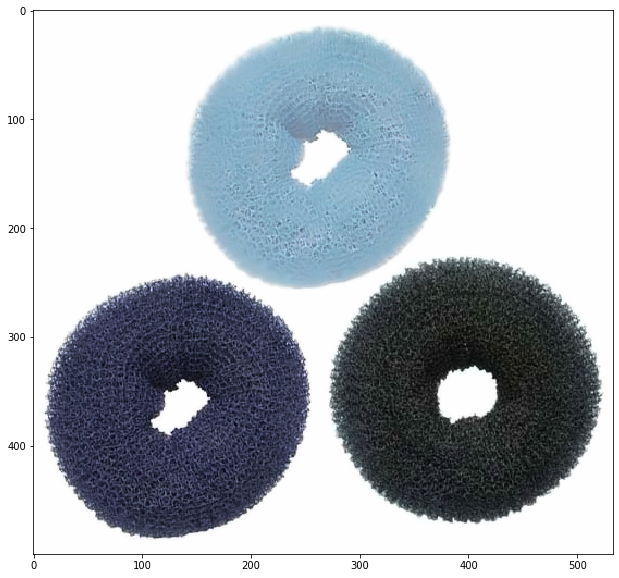

In [0]:
plt.figure(figsize = (50,10))   
plt.imshow(cv2.cvtColor(np.asarray(img), cv2.COLOR_BGR2RGB))

In [0]:
blur.shape

(500, 533, 3)

In [0]:
# We're going to use 7 features to segment
numFeatures = 7
# Create a data vector, with 7 values
#  blue
#  green
#  red
#  x
#  y
#  red - blue and
#  red - green 
#
# for every pixel in the image

# Red-blue and red-green is used for improve clustering
Z = np.ndarray(shape=(imgWidth * imgHeight, numFeatures), dtype = float)

Z = np.float32(Z)

# Load data vector with the 7 values
for y in tqdm(range(0, imgHeight), ascii=True):
    for x in range(0, imgWidth):
        xy = (x, y)
        rgb = img.getpixel(xy)
        Z[x + y * imgWidth, 0] = rgb[0]           # blue
        Z[x + y * imgWidth, 1] = rgb[1]           # green
        Z[x + y * imgWidth, 2] = rgb[2]           # red
        # Experimentally, reduce the influence of the x,y components by dividing them by 10
        Z[x + y * imgWidth, 3] = x / 10           # x
        Z[x + y * imgWidth, 4] = y / 10           # y 
        Z[x + y * imgWidth, 5] = rgb[2] - rgb[0]  # red - blue
        Z[x + y * imgWidth, 6] = rgb[2] - rgb[1]  # red - green

# We need a second copy of our initial vector
# for OpenCV's K-means implementation.
Z2 = Z.copy()

100%|##########| 500/500 [00:00<00:00, 574.49it/s]


# _K_-means Clustering

 _k_-means clustering aims to partition _n_ observations into _k_ clusters such that each observation is in the cluster with the nearest mean to it.

In general, the problem is computationally difficult (NP-hard).  However, heuristic algorithms are normally employed and these converge quickly.

The most common algorithm uses an iterative refinement technique.  Due to its ubiquity it is often just called the
_k_-means algorithm.

For image processing, to split a set of pixels into 3 sets.

Arbitrarily pick any one pixel from the image and make that the center of cluster one.
Then pick any other pixel from the image and make that the center of cluster two.
Then pick any other pixel from the image and make that the center of cluster three.

The algorithm proceeds by alternating between the following two steps:

1. *Assignment Step:* Assign each pixel to the 'closest' cluster.  Proximity is normally calculated using Euclidean distance.
2. *Update the means of the clusters:* Calculate the new means of the pixels in the new clusters.
    
3. Repeat steps 1 and 2 until the assignments no longer change or for a fixed number of iterations.

 Note: The algorithm may fail to find the optimum solution and the result may depend on the two pixels randomly chosen at the start.

Let's apply this technique to our hair donut image.

First, we'll implement the algorithm ourselves initially in order to gain a deeper understanding of the technique.
Then we'll use OpenCV's K-means implementation as its faster. But on Google colab it works in good times.

First of all, we have to load our libraries:

At this point, we've effectively assembled 'Z' which contains 7 columns (blue, red, green, an x position divided by 10, a y position divided by 10, a term representing red-blue and a term representing red-green) and contains a row for each pixel in the image. 



Now, lets turn our attention to another key data structure that we'll use --> clusterCentres.

We'll need to create an array of clusterCenters.  In our example, 'K' = 3, i.e. we're separating into three clusters.  So, we'll need three clusterCentres.  Each cluster center must contain information about each of our features.

We have 7 features, so we end up with a structure containing 3 vectors, each vector containing 7 elements.


In [0]:
# For this example, we are going to divide into three clusters.
# So, k = 3
K = 3

# Create our cluster centers.

# clusterCenter is an arrangement of 'K' vectors
# each vector 'contains' our 7 columns or features that we described 
# in the preceding code block.
# For example, eventually, clusterCenters[0][0] will contain
# the mean of the 'blue's in cluster 0 and clusterCenters[0][1] will
# contain the mean of the 'red's in cluster 0, etc.
clusterCenters = np.ndarray(shape=(K,numFeatures))

# Initialise each element of three of our vectors 
# to rand values (each random number being between the max'es & mins of that feature in Z)
maxVals = np.amax(Z)
minVals = np.amin(Z)
for i, _ in enumerate(clusterCenters):
        clusterCenters[i] = np.random.uniform(minVals, maxVals, numFeatures)

# So now we have created our cluster Centers and initialized each clusterCenter's vector

Now we must create a data vector which has one entry for every pixel in the original image.
We make this data vector contain integers as we plan to use it to remember what cluster
each pixel in the image belongs to (either 0 or 1).

In [0]:
# Let's create a data vector with an integer to represent whatever cluster a pixel belongs to. 
# We need one entry for each pixel - so that's a total of imgWidth * imgHeight's entries.
pixelClusterMembership = np.ndarray(shape=(imgWidth * imgHeight), dtype = int)


Now that we have created the data structures we need, we can start to implement the
algorithm.

We will iterate over the entire process 10 times.

In each iteration, we will:
a) assign each pixel to either cluster 0 or cluster 1 (using Euclidean distance from the clusterCenters as our measure)
b) calculate the mean of the pixels in each cluster to form a new pair of clusterCenters.

This might take up to one minute to run.

In [0]:
iterations = 10

# For each iteration:
for iteration in tqdm(range(iterations), ascii=True):
    # Part 1: Set each pixel to its cluster
    
    # use numpy to efficiently subtract  cluster 
    # center's vectors from all of the vectors representing
    # the pixels in the image.
    distances = Z[:,None,:] - clusterCenters[None,:,:]
    
    # Square every element in distances
    distances_sq = distances**2
    
    # Get the sums of the squared vectors
    distance_sum = np.sum(distances_sq, axis=2)
    
    # get the square root of those sums
    distance = np.sqrt(distance_sum)

    # Pick the indexes of the elements with the smaller of 
    # the two distances for each point
    pixelClusterMembership = np.argmin(distance, axis=1)
       
    # Part 2: update each cluster's centroid
    #print('clusterCenters.shape: ', clusterCenters.shape)
    for i in range(K):
        # Create an empty list of pixels in this cluster
        pixelsInCluster = []

        # For each pixel, retrieve it's cluster membership
        for index, item in enumerate(pixelClusterMembership):
            # if it is member of the current cluster of interest
            if item == i:
                # add it's features to the list of pixels in the cluster
                pixelsInCluster.append(Z[index])

        if len(pixelsInCluster) == 0:
            pixelsInCluster.append(Z[0])

        # Now, for each cluster, simply get the mean of each of its 7 features
        pixelsInCluster = np.array(pixelsInCluster)
        clusterCenters[i] = np.mean(pixelsInCluster, axis=0)


100%|##########| 10/10 [00:06<00:00,  1.67it/s]


Now, we have run ten iterations of our algorithm, let's plot the results so far and see how well it is working.

In [0]:
# Let's display an image based around what we've just done
# and convince ourselves its segmenting reasonably well (albeit slowly :-)
            
# Let's (effectively) replace every pixel in the original image
# with the rgb values from the mean of the cluster that pixel
# is now in.
outVec = np.ndarray(shape=(imgWidth * imgHeight, 3), dtype = int)
for index, item in enumerate(tqdm(pixelClusterMembership)):
    outVec[index][0] = int(round(clusterCenters[item][2]))
    outVec[index][1] = int(round(clusterCenters[item][1]))
    outVec[index][2] = int(round(clusterCenters[item][0]))

# Save and display image
img = Image.new("RGB", (imgWidth, imgHeight))

for y in tqdm(range(imgHeight), ascii=True):
    for x in range(imgWidth):
        img.putpixel((x, y), (int(outVec[y*imgWidth + x][0]), int(outVec[y * imgWidth + x][1]), int(outVec[y * imgWidth + x][2])))

#plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(img)



 24%|##4       | 122/500 [00:00<00:00, 613.04it/s]

This approach (our own implementation of K-Means) can be slow.  Sometimes running the algorithm for only ten iterations is not enough to sufficient to achieve the type of separation we want.  This hand-made approach, while having the relatively easy to understand, can suffer from performance issues.

Now that we understand how the algorithm works, we'll run OpenCV's more optimal k-means implemention so we can actually get somewhere at a reasonable pace! 

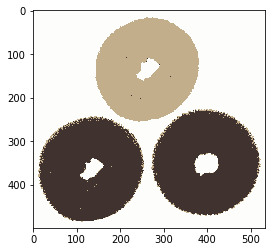

In [0]:
# OpenCV's K-means 
criteria = (cv2.TERM_CRITERIA_MAX_ITER, i+1, 0.1)
ret, label, center = cv2.kmeans(Z2,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Convert center back into unsigned bytes
center = np.uint8(center)

# reshape the RGB values from our cv2.kmeans results into
# an image.
rgb = center[:,0:3]
res = rgb[label.flatten()]
img = res.reshape((imgHeight,imgWidth, 3))

plt.imshow(img)


As we have seen, the OpenCV's k-means implementation performs much better than our basic implementation.  As the preceding image shows, we can use clustering techniques such as k-means when trying to segment relatively straightforward images.  

We will use the drawContour() technique from the first lab to extract the starfish (which is the largest image) from this image.

In [0]:
#Make a copy of the image recieved from k-Means
eroded = img.copy()

In [0]:
#Convert it to gray color space
eroded = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

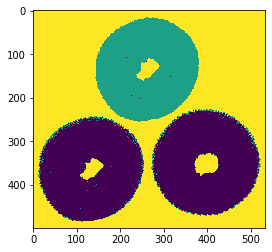

In [0]:
plt.imshow(eroded)

In [0]:
#Lets us use the adaptive thresholding as with other threshold function top most donut was lost as it is light coloured
eroded = cv2.adaptiveThreshold(eroded,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,2)

In [0]:
plt.imshow(eroded)

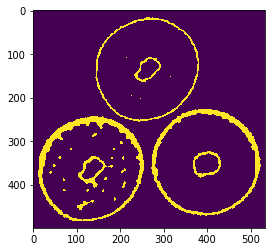

In [0]:
#Reduce the dots on the foreground
closingKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
eroded1 = cv2.morphologyEx(eroded, cv2.MORPH_CLOSE, closingKernel)
plt.imshow(eroded1)

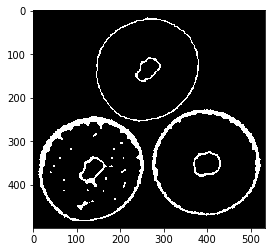

In [0]:
#Erode and give the closing edges for the donut boundaries
elKernelErode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
eroded2 = cv2.erode(eroded1,elKernelErode,iterations=1)
# END YOUR CODE HERE

plt.imshow(eroded2, cmap='gray')

In [0]:
#The following code is not run as there is not much noise outside of the donuts near the margins

#p = int(img.shape[1] * 0.22)
#q = int(img.shape[0] * 0.13)
#eroded[:, 0:p] = 0
#eroded[:, img.shape[1] - p:] = 0
#eroded[:q, :] = 0
#eroded[img.shape[0] - q:, :] = 0
#plt.imshow(eroded, cmap='gray')

In [0]:
#Find contours from the image
images, contours, hierarchy = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [0]:
print("Number of conrours:"+str(len(contours)))

Number of conrours:6


here
here
here


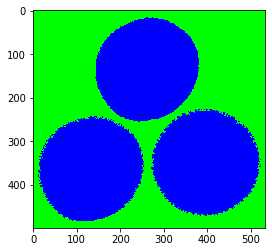

In [0]:

# Sort the candidates by size, and just keep the largest one
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:3]

# Lets create two images, initially all zeros (i.e. black)
# One image will be filled with 'Blue' wherever we think there's some starfish
# The other image will be filled with 'Green' whereever we think there's not some starfish
h, w, num_c = img.shape
segmask = np.zeros((h, w, num_c), np.uint8)
stencil = np.zeros((h, w, num_c), np.uint8)
i=0
# I know we've only one contour, but - in general - we'd expect to have more contours to deal with
for c in contours:
    
    i=i+1
    print("Shape :", str(i))
    # Fill in the starfish shape into segmask
    cv2.drawContours(segmask, [c], 0, (255, 0, 0), -1)
    # Lets fill in the starfish shape into stencil as well
    # and then re-arrange the colors using numpy
    cv2.drawContours(stencil, [c], 0, (255, 0, 0), -1)
    stencil[np.where((stencil==[0,0,0]).all(axis=2))] = [0, 255, 0]
    stencil[np.where((stencil==[255,0,0]).all(axis=2))] = [0, 0, 0]

# Now, lets create a mask image by bitwise ORring segmask and stencil together
mask = cv2.bitwise_or(stencil, segmask)

plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

In [0]:
# Now, lets just blend our original image with our mask

#Blend the original image 'img' and our mask 'mask'
# in any way you see fit, and store it in a variable called output

#Using bitwise_xor to see the whole mask against the original image
output = cv2.bitwise_xor(mask, np.asarray(blur))


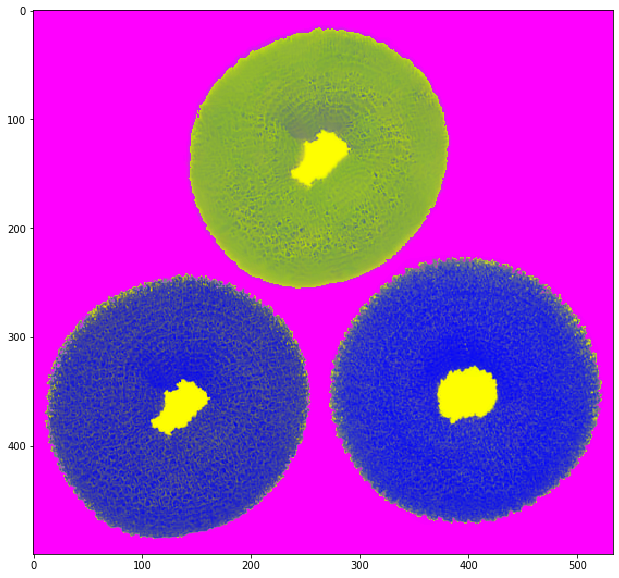

In [0]:
plt.figure(figsize = (50,10))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

# Conclusions

We have seen in this lab that image clustering can be successfully used for segmentation of relatively simple images. 

K-means can operate in an unsupervised manner. The selection of the features and the normalization of those features can necessitate careful selection and empirical experimentation. 

The criteria for the selection of the initial points has to be given consideration.  It is a known weakness in K-means that if we are unlucky with our initial selection of pixels to grow the clusters around, we may cluster poorly.  OpenCV's K-means gets around this by repeating the algorithm several times and choosing the best outcome.
